In [1]:
from typing import Tuple
import numpy as np
from PIL import Image


def rgb2yuv_np(rgb: np.ndarray) -> np.ndarray:
    """
    Convert RGB (HxWx3, uint8) to YUV (HxWx3, uint8), BT.601 limited-range style.
    This is a floating-point, readable reference (NOT bit-true to any HLS).
    """
    assert rgb.dtype == np.uint8 and rgb.ndim == 3 and rgb.shape[-1] == 3, "rgb must be HxWx3 uint8"
    r = rgb[..., 0].astype(np.float32)
    g = rgb[..., 1].astype(np.float32)
    b = rgb[..., 2].astype(np.float32)

    # BT.601-ish (limited range), float version
    y = 16.0  + ( 65.738 * r + 129.057 * g +  25.064 * b) / 256.0
    u = 128.0 + (-37.945 * r -  74.494 * g + 112.439 * b) / 256.0
    v = 128.0 + (112.439 * r -  94.154 * g -  18.285 * b) / 256.0

    yuv = np.stack([y, u, v], axis=-1)
    yuv = np.clip(np.round(yuv), 0, 255).astype(np.uint8)
    return yuv

def scale_y_np(yuv: np.ndarray, y_scale: float) -> np.ndarray:
    """
    Multiply the Y (luma) channel by y_scale; clamp result to [0,255].
    yuv: HxWx3 uint8 (Y,U,V)
    """
    assert yuv.dtype == np.uint8 and yuv.ndim == 3 and yuv.shape[-1] == 3, "yuv must be HxWx3 uint8"
    out = yuv.copy()
    y = out[..., 0].astype(np.float32) * float(y_scale)
    out[..., 0] = np.clip(np.round(y), 0, 255).astype(np.uint8)
    return out

def yuv2rgb_np(yuv: np.ndarray) -> np.ndarray:
    """
    Convert YUV (HxWx3, uint8) back to RGB (HxWx3, uint8), BT.601 limited-range style.
    Floating-point math; clamp to [0,255].
    """
    assert yuv.dtype == np.uint8 and yuv.ndim == 3 and yuv.shape[-1] == 3, "yuv must be HxWx3 uint8"
    y = yuv[..., 0].astype(np.float32) - 16.0
    u = yuv[..., 1].astype(np.float32) - 128.0
    v = yuv[..., 2].astype(np.float32) - 128.0

    r = (298.082 * y + 408.583 * v) / 256.0
    g = (298.082 * y - 100.291 * u - 208.120 * v) / 256.0
    b = (298.082 * y + 516.412 * u) / 256.0

    rgb = np.stack([r, g, b], axis=-1)
    rgb = np.clip(np.round(rgb), 0, 255).astype(np.uint8)
    return rgb

# --- Full pipeline ---

def yuv_filter_numpy(rgb: np.ndarray, scale_Y: float) -> np.ndarray:
    """
    Full pipeline: RGB -> YUV -> scale Y -> RGB.
    Return HxWx3 uint8 RGB.
    """
    yuv = rgb2yuv_np(rgb)
    yuv_scaled = scale_y_np(yuv, scale_Y)
    rgb_out = yuv2rgb_np(yuv_scaled)
    return rgb_out

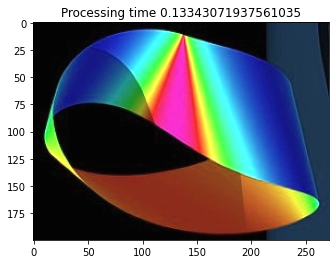

In [2]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('input.jpg')

# If the image has an alpha channel, remove it
if image.shape[2] == 4:
    image = image[:, :, :3]

# If the image is in float format (0-1), convert it to uint8 (0-255)
if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

start_time = time.time()
filtered_image = yuv_filter_numpy(image, 1.2)
processing_time = time.time() - start_time

plt.imshow(filtered_image)
plt.title(f"Processing time {processing_time}")
plt.show()